<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

### **Waveform LiDAR Metric Calculator**  
**Author: Ramesh Bhatta, CIS, RIT**  
 
*This Code file takes in the each 1d- array of waveform lidar data and calculates multiple waveform metrics that can be used in modelling different biophysical parameters.*
</div>


In [69]:
# Importing Libraries

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
from scipy.signal import find_peaks
import os

In [70]:
## Predefined plot preferences

# Define text sizes
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

# Apply text size settings
plt.rc('font', size=SMALL_SIZE)          # Default font size
plt.rc('axes', titlesize=MEDIUM_SIZE)   # Axis title font size
plt.rc('axes', labelsize=MEDIUM_SIZE)   # Axis labels font size
plt.rc('xtick', labelsize=SMALL_SIZE)   # X-axis tick label font size
plt.rc('ytick', labelsize=SMALL_SIZE)   # Y-axis tick label font size
plt.rc('legend', fontsize=SMALL_SIZE)   # Legend font size
plt.rc('figure', titlesize=BIGGER_SIZE) # Figure title font size

In [71]:
# Read the raw waveform data as well as deconvolved waveform data

# Flightline Data
fl = 'flightline1'
res = 5 # meter resolution
rawdata_directory = f'../../sim_data/Harvard_forest/{res}m_res/waveform_data_{res}m/raw_data/16ns_data/{fl}'         # Simulation generated waveforms are in .txt file extention
RL_deconvdata_directory = f'../../sim_data/Harvard_forest/{res}m_res/waveform_data_{res}m/deconvolved_data/RL_deconvolved/16ns_data/{fl}' # RL Deconvolved waveforms are in .npy file extension
gold_deconvdata_directory = f'../../sim_data/Harvard_forest/{res}m_res/waveform_data_{res}m/deconvolved_data/gold_deconvolved/16ns_data/{fl}' # Gold Deconvolved waveforms are in .npy file extension
# LAI_data = line5_LAI

# Reading all the waveforms
raw_waveforms = []
RL_deconv_waveforms = []
gold_deconv_waveforms = []

# Custom sorting function to sort files numerically by their profile number
def numeric_sort(file_name):
    if file_name.startswith("profile_") and file_name.endswith(".txt"):
        profile_number = int(file_name.split("_")[-1].split(".")[0])  # Extract numeric part
        return profile_number
    return float('inf')  # Put non-matching files at the end

# Process each raw profile file in numeric order
for file_name in sorted(os.listdir(rawdata_directory), key=numeric_sort):
    if file_name.startswith("profile_") and file_name.endswith(".txt"):
        # Read raw waveform data
        raw_file_path = os.path.join(rawdata_directory, file_name)
        raw_data = np.loadtxt(raw_file_path, usecols=2)  # Extract the third column (waveform)
        raw_waveforms.append(raw_data)
        
        # Generate the corresponding deconvolved file name
        profile_number = file_name.split("_")[-1].split(".")[0]  # Extract the profile number
        deconv_file_name = f"deconvolved_profile_{profile_number}.npy"
        RL_deconv_file_path = os.path.join(RL_deconvdata_directory, deconv_file_name)
        gold_deconv_file_path = os.path.join(gold_deconvdata_directory, deconv_file_name)
 
        # Read Richardson-Lucy deconvolved waveform data if it exists
        if os.path.exists(RL_deconv_file_path):
            RL_deconv_data = np.load(RL_deconv_file_path)
            RL_deconv_waveforms.append(RL_deconv_data)
        else:
            print(f"Warning: No RL deconvolved file for {file_name}")

        # Read Gold deconvolved waveform data if it exists
        if os.path.exists(gold_deconv_file_path):
            gold_deconv_data = np.load(gold_deconv_file_path)
            gold_deconv_waveforms.append(gold_deconv_data)
        else:
            print(f"Warning: No gold deconvolved file for {file_name}")

# Convert lists to numpy arrays for easier processing
raw_waveforms = np.array(raw_waveforms, dtype=object)  # Object dtype for variable-length arrays
RL_deconv_waveforms = np.array(RL_deconv_waveforms, dtype=object)
gold_deconv_waveforms = np.array(gold_deconv_waveforms, dtype=object)

# Analyze the shapes
print("Raw waveforms shape:", raw_waveforms.shape)
print("RL deconvolved waveforms shape:", RL_deconv_waveforms.shape)
print("Gold deconvolved waveforms shape:", gold_deconv_waveforms.shape)

Raw waveforms shape: (100, 1001)
RL deconvolved waveforms shape: (100, 1001)
Gold deconvolved waveforms shape: (100, 1001)


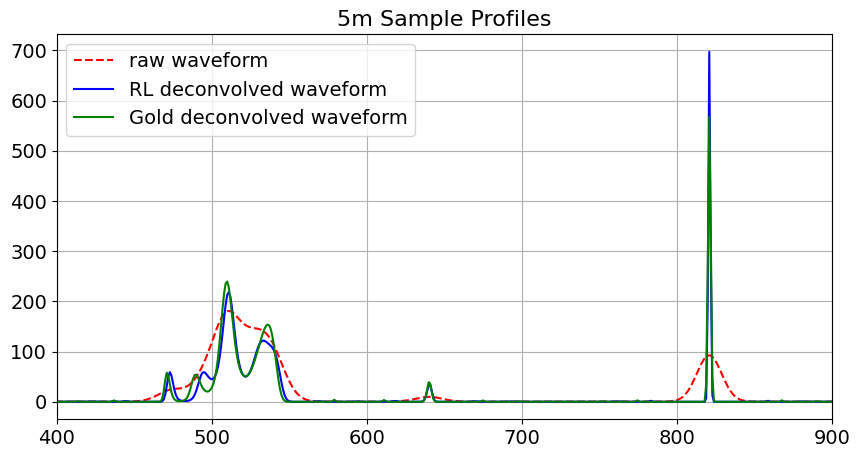

In [72]:
# Plot sample Raw and deconvolved waveforms:
n = 99                  # Enter the sample number
fig = plt.figure(figsize=(10,5))
plt.plot(raw_waveforms[n], color = 'red', label = 'raw waveform', linestyle = 'dashed')
plt.plot(RL_deconv_waveforms[n], color = 'blue', label = 'RL deconvolved waveform')
plt.plot(gold_deconv_waveforms[n], color = 'green', label = 'Gold deconvolved waveform')
plt.title(f'{res}m Sample Profiles')
plt.grid(which='both')
plt.xlim(400, 900)
plt.legend()
plt.show()

**1. Centroid and Radius of Gyration (1D)**

In [73]:
# Centroid and radius of gyration of waveform:

# Each waveform is a 1D array of intensity values.
waveforms = raw_waveforms[:]

# Initialize lists to store centroid and radius of gyration for each waveform
centroids1d = []
radii_of_gyration1d = []

# Process each waveform
for waveform in waveforms:

    # Correct for baseline (remove minimum value to avoid negative intensities)
    waveform_corrected = np.maximum(waveform - np.max(waveform)*0.05, 0)
    
    # Define the position of each time bin (assuming regular sampling)
    x = np.arange(len(waveform_corrected))
    
    # Calculate total energy (sum of intensities)
    total_energy = np.sum(waveform_corrected)
    
    # Check if there's any energy in the waveform to avoid division by zero
    if total_energy == 0:
        centroids1d.append(None)
        radii_of_gyration1d.append(None)
        continue
    
    # 1. Centroid calculation (Intensity-weighted average position)
    C_x = np.sum(x * waveform_corrected) / total_energy
    
    # 2. Radius of Gyration (RG) calculation
    RG = np.sqrt(np.sum((x - C_x) ** 2) / total_energy)
    
    # Store the results
    centroids1d.append(C_x)
    radii_of_gyration1d.append(RG)

# Convert results to numpy arrays 
centroids1d = np.array(centroids1d)
radii_of_gyration1d = np.array(radii_of_gyration1d)

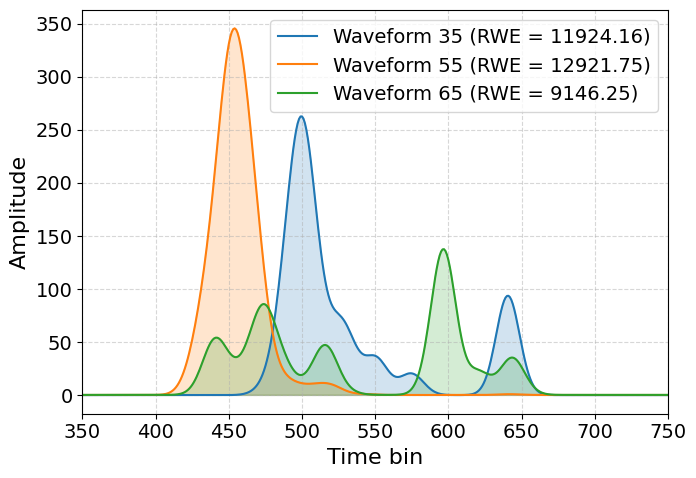

In [74]:
## VISUALIZING TOTAL RETURN ENERGY

# Example user-supplied indices
subset_indices = [35, 55, 65]  # replace with any indices you'd like

# Colors for consistency
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(7, 5))

for i, idx in enumerate(subset_indices):
    waveform = np.array(waveforms[idx]).astype(float)
    time = np.arange(len(waveform))
    rwe = np.sum(waveform)  # Total return waveform energy

    label = f'Waveform {idx} (RWE = {rwe:.2f})'
    plt.plot(time, waveform, label=label, color=colors[i])
    plt.fill_between(time, 0, waveform, alpha=0.2, color=colors[i])

plt.xlabel('Time bin')
plt.ylabel('Amplitude')
# plt.title('LiDAR Waveforms and Total Return Energy')
plt.legend()
plt.grid(True, alpha=0.5, linestyle='--')
plt.tight_layout()
plt.xlim(350, 750)
plt.show()


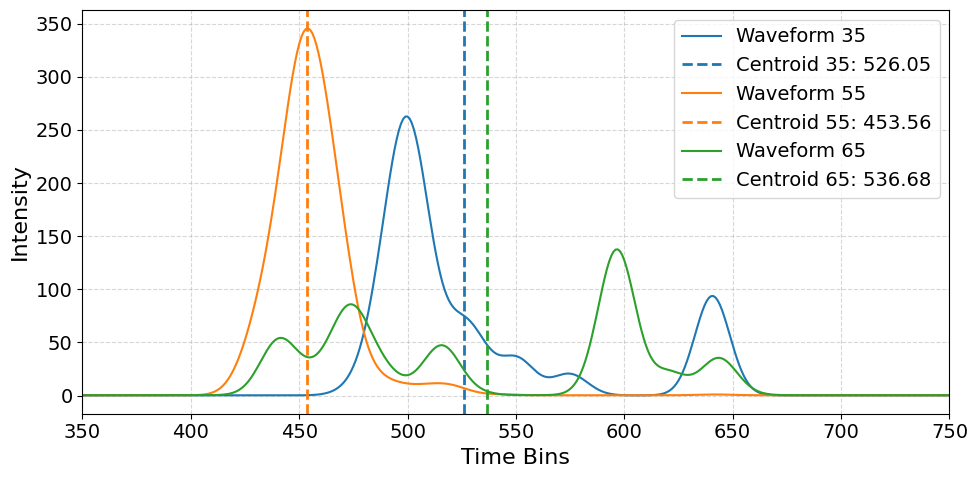

In [75]:
## VISUALIZING CENTROIDS

# Define subset indices (select the samples you want to visualize)
subset_indices = [35, 55, 65]  # Replace with specific indices

# Create the figure and a single plot
fig, ax = plt.subplots(figsize=(10, 5))

# Loop through each index and plot the corresponding waveform on the same axes
for idx in subset_indices:
    waveform = waveforms[idx]
    centroid = centroids1d[idx]
    RG = radii_of_gyration1d[idx]
    
    x = np.arange(len(waveform))  # Time bins
    
    # Plot the waveform and capture the line object
    line, = ax.plot(x, waveform, label=f'Waveform {idx}')
    
    # Use the same color as the waveform for the centroid line
    ax.axvline(centroid, color=line.get_color(), linestyle='--', alpha=1, linewidth=2, 
               label=f'Centroid {idx}: {np.round(centroid, 2)}')
    
    # Optionally, highlight the radius of gyration
    # ax.axvspan(centroid - RG, centroid + RG, color=line.get_color(), alpha=0.2, 
    #            label=f'RG {idx}: {np.round(RG)}')

# Set axis labels
ax.set_xlabel('Time Bins')
ax.set_ylabel('Intensity')
ax.set_xlim(350, 750)
ax.grid(True, alpha=0.5, linestyle='--')
ax.legend(loc='upper right')

# Show plot
plt.tight_layout()
plt.show()


**2. Metrics Based on Literatures:**  
- **Height metrics: Canopy Height, RH25, RH50(HOME), RH75, RH100**
- **Waveform Based: Num_peaks, WD(waveform_distance), ROUGH(Rougness of outermost canopy),**  
  **FS(front slope angle), VDR(Vertical distribution ratio), RWE(Total return energy).**

In [76]:
# Initialize lists to store metrics

rh25_values = []
rh50_values = []  # This is HOME
rh75_values = []
rh100_values = []
canopy_heights = []
number_of_peaks = []
front_slope_angles = []
rough_values = []
waveform_distances = []
htmr_values = []
vdr_values = []
total_return_energies = []

# Process each waveform
for waveform in waveforms:
    # Correct for baseline (remove minimum value to avoid negative intensities)
    waveform_corrected = np.maximum(waveform - np.min(waveform), 0)
    
    # Calculate total energy (sum of intensities) for RWE
    total_energy = np.sum(waveform_corrected)
    total_return_energies.append(total_energy)
    
    # Check if there's any energy in the waveform to avoid division by zero
    if total_energy == 0:
        rh25_values.append(None)
        rh50_values.append(None)
        rh75_values.append(None)
        rh100_values.append(None)
        canopy_heights.append(None)
        number_of_peaks.append(0)
        front_slope_angles.append(None)
        rough_values.append(None)
        waveform_distances.append(None)
        htmr_values.append(None)
        vdr_values.append(None)
        continue

    # Calculate cumulative energy
    cumulative_energy = np.cumsum(waveform_corrected)
    
    # Peak detection
    peaks, _ = find_peaks(waveform_corrected, height=np.max(waveform_corrected) * 0.025)  # Adjustable threshold

    # Number of peaks
    num_peaks = len(peaks)
    number_of_peaks.append(num_peaks)

    # Ground peak: last detected peak
    if num_peaks > 0:
        ground_peak = peaks[-1]
    else:
        rh25_values.append(None)
        rh50_values.append(None)
        rh75_values.append(None)
        rh100_values.append(None)
        canopy_heights.append(None)
        front_slope_angles.append(None)
        rough_values.append(None)
        waveform_distances.append(None)
        htmr_values.append(None)
        vdr_values.append(None)
        continue

    # Find the start of the first peak (inflection point) using the first derivative
    derivative = np.gradient(waveform_corrected)
    first_peak_start = None
    for i in range(len(derivative)):
        if derivative[i] > 0.0:  # First non-zero derivative indicates inflection point
            first_peak_start = i
            break

    # Find the end of the waveform (last inflection point)
    last_inflection_point = None
    for i in range(peaks[-1]+1, len(derivative)):
        if derivative[i] == 0:
            last_inflection_point = i
            break

    # RH Metrics (Relative Heights):
    if num_peaks > 0:
        rh25 = peaks[-1] - np.searchsorted(cumulative_energy, (1 - 0.25) * total_energy)
        rh50 = peaks[-1] - np.searchsorted(cumulative_energy, (1 - 0.50) * total_energy)   # HOME
        rh75 = peaks[-1] - np.searchsorted(cumulative_energy, (1 - 0.75) * total_energy) 
    else:
        rh25, rh50, rh75 = None, None, None

    # RH100: Distance from the ground peak to the first inflection point
    if first_peak_start is not None:
        rh100 = ground_peak - first_peak_start
    else:
        rh100 = None

    # Store RH values
    rh25_values.append(rh25)
    rh50_values.append(rh50)
    rh75_values.append(rh75)
    rh100_values.append(rh100)

    # Canopy height: distance between first peak and ground peak
    if num_peaks >= 2:
        first_peak = peaks[0]
        canopy_height = ground_peak - first_peak
    else:
        canopy_height = None
    canopy_heights.append(canopy_height)
    
    # Waveform Distance (WD)
    if first_peak_start is not None and last_inflection_point is not None:
        waveform_distance = last_inflection_point - first_peak_start
    else:
        waveform_distance = None
    waveform_distances.append(waveform_distance)
    
    # ROUGH: Horizontal distance (time bins) from the inflection point to the first peak
    if first_peak_start is not None and len(peaks) > 0:
        first_peak = peaks[0]
        rough = first_peak - first_peak_start  # This is the horizontal distance in time bins
    else:
        rough = None
    rough_values.append(rough)
    
    # Front slope angle
    if first_peak_start is not None and len(peaks) > 0:
        first_peak = peaks[0]
        height_first_peak = waveform_corrected[first_peak]
        horizontal_distance = first_peak - first_peak_start
        if horizontal_distance > 0:  # Ensure no division by zero
            front_slope_angle = np.arctan(height_first_peak / horizontal_distance) * (180 / np.pi)  # Degrees
        else:
            front_slope_angle = None
    else:
        front_slope_angle = None
    front_slope_angles.append(front_slope_angle)

    # Height to Median Ratio (HTMR) and Vertical Distribution Ratio (VDR)
    if waveform_distance is not None and waveform_distance > 0:
        htmr = rh50 / waveform_distance  # HOME/WD
        vdr = 1 - htmr  # (WD-HOME)/WD = 1 - HTMR
    else:
        htmr = None
        vdr = None
    htmr_values.append(htmr)
    vdr_values.append(vdr)

# Convert results to numpy arrays for easy handling
rh25_values = np.array(rh25_values)
rh50_values = np.array(rh50_values)  # HOME
rh75_values = np.array(rh75_values)
rh100_values = np.array(rh100_values)
canopy_heights = np.array(canopy_heights)
number_of_peaks = np.array(number_of_peaks)
rough_values = np.array(rough_values)
front_slope_angles = np.array(front_slope_angles)
waveform_distances = np.array(waveform_distances)
htmr_values = np.array(htmr_values)
vdr_values = np.array(vdr_values)
total_return_energies = np.array(total_return_energies)

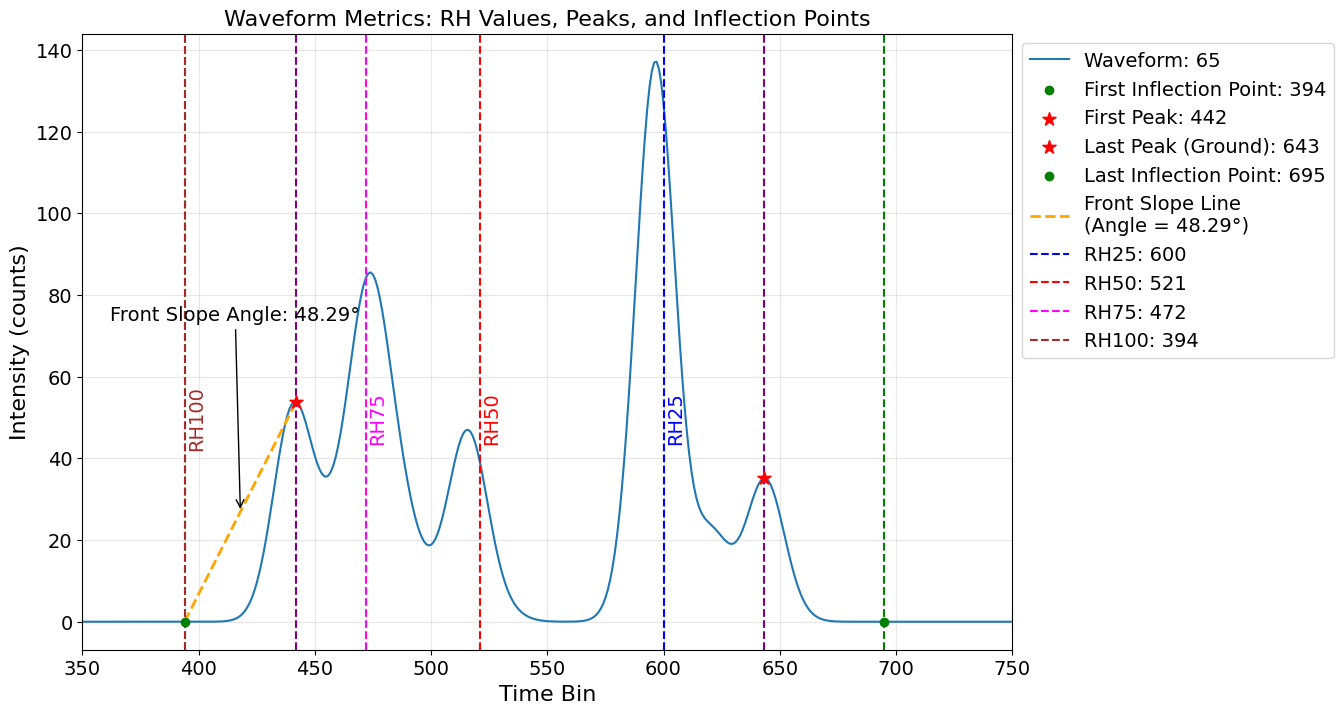

In [77]:
# Visualization for a sample waveform

sample_index = 65
waveform = waveforms[sample_index]
waveform_corrected = np.maximum(waveform - np.min(waveform), 0)

# Retrieve precomputed values
num_peaks = number_of_peaks[sample_index]
rough = rough_values[sample_index]  # Horizontal distance (time bins)
front_slope_angle = front_slope_angles[sample_index]

# Compute the derivative 
derivative = np.gradient(waveform_corrected)

# Find peaks in the waveform
peaks, _ = find_peaks(waveform_corrected, height=np.max(waveform_corrected) * 0.025)

# Compute cumulative energy
total_energy = np.sum(waveform_corrected)
cumulative_energy = np.cumsum(waveform_corrected)

# Identify ground peak and last inflection point (end of last peak)
if len(peaks) > 0:
    last_peak = peaks[-1]
    last_inflection_point = None
    for i in range(last_peak+1, len(derivative)):
        if derivative[i] == 0.0:  # Last inflection point
            last_inflection_point = i
            break

# Calculate RH values
rh25 = None
rh50 = None
rh75 = None
rh100 = None

if last_inflection_point is not None:
    rh25 = last_inflection_point - np.searchsorted(cumulative_energy, (1 - 0.25) * total_energy) 
    rh50 = last_inflection_point - np.searchsorted(cumulative_energy, (1 - 0.50) * total_energy)
    rh75 = last_inflection_point - np.searchsorted(cumulative_energy, (1 - 0.75) * total_energy)

if len(peaks) > 0:
    first_peak_start = None
    for i in range(len(derivative)):
        if derivative[i] > 0.0:  # Start of the first peak
            first_peak_start = i
            break
    rh100 = last_inflection_point - first_peak_start if first_peak_start is not None else None

# Plot the waveform, derivative, and highlight metrics
plt.figure(figsize=(12, 8))

# Plot the waveform
x = np.arange(len(waveform_corrected))
plt.plot(x, waveform_corrected, label=f'Waveform: {sample_index}', linewidth=1.5)

# Plot the derivative
# plt.plot(x, derivative, label='Derivative', linestyle='--', color='k')

# Highlight the first inflection point
if first_peak_start is not None:
    plt.scatter(first_peak_start, waveform_corrected[first_peak_start], color='green', label=f'First Inflection Point: {first_peak_start}', zorder=5)
    plt.axvline(first_peak_start, color='green', linestyle='--')

# Highlight the first peak
if len(peaks) > 0:
    first_peak = peaks[0]
    plt.scatter(first_peak, waveform_corrected[first_peak], color='red',marker='*',s=100, label=f'First Peak: {first_peak}', zorder=5)
    plt.axvline(first_peak, color='purple', linestyle='--')

# Highlight the Kast peak
if len(peaks) > 0:
    last_peak = peaks[-1]
    plt.scatter(last_peak, waveform_corrected[last_peak], color='red',marker='*',s=100, label=f'Last Peak (Ground): {last_peak}', zorder=5)
    plt.axvline(last_peak, color='purple', linestyle='--')

# Highlight the last inflection point
if last_inflection_point is not None:
    plt.scatter(last_inflection_point, waveform_corrected[last_inflection_point], color='green', label=f'Last Inflection Point: {last_inflection_point}', zorder=5)
    plt.axvline(last_inflection_point, color='green', linestyle='--')

# Draw the front slope angle line
if front_slope_angle is not None and first_peak_start is not None and len(peaks) > 0:
    plt.plot(
        [first_peak_start, first_peak],
        [waveform_corrected[first_peak_start], waveform_corrected[first_peak]],
        color='orange',
        linestyle='--',
        label=f'Front Slope Line\n(Angle = {front_slope_angle:.2f}°)',
        linewidth=2
    )

# Annotate front slope angle
if front_slope_angle is not None and first_peak_start is not None:
    plt.annotate(f'Front Slope Angle: {front_slope_angle:.2f}°',
                 xy=((first_peak_start + first_peak) / 2, (waveform_corrected[first_peak_start] + waveform_corrected[first_peak]) / 2),
                 xytext=(first_peak - 80, waveform_corrected[first_peak] + 20),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))

# Highlight RH values
if rh25 is not None:
    plt.axvline(last_inflection_point - rh25, color='blue', linestyle='--', label=f'RH25: {(last_inflection_point - rh25)}')
if rh50 is not None:
    plt.axvline(last_inflection_point - rh50, color='red', linestyle='--', label=f'RH50: {last_inflection_point - rh50}')
if rh75 is not None:
    plt.axvline(last_inflection_point - rh75, color='magenta', linestyle='--', label=f'RH75: {last_inflection_point - rh75}')
if rh100 is not None:
    plt.axvline(first_peak_start, color='brown', linestyle='--', label=f'RH100: {last_inflection_point - rh100}')

# Annotate RH values
if rh25 is not None:
    plt.text(last_inflection_point - rh25+5, +50, 'RH25', color='blue',
             verticalalignment='center', rotation=90, horizontalalignment='center')
if rh50 is not None:
    plt.text(last_inflection_point - rh50+5, +50, 'RH50', color='red', 
             verticalalignment='center', rotation=90, horizontalalignment='center')
if rh75 is not None:
    plt.text(last_inflection_point - rh75+5, +50, 'RH75', color='magenta', 
             verticalalignment='center', rotation=90, horizontalalignment='center')
if rh100 is not None:
    plt.text(first_peak_start+5, +50, 'RH100', color='brown', 
             verticalalignment='center', rotation=90, horizontalalignment='center')

# Add labels and legend
plt.xlabel('Time Bin')
plt.ylabel('Intensity (counts)')
plt.title('Waveform Metrics: RH Values, Peaks, and Inflection Points')
plt.xlim(350, 750)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

plt.grid(alpha=0.3)
plt.show()


In [78]:
# Print results for a sample waveform

s = 65
print("RH25:", rh25_values[s])
print("RH50 (HOME):", rh50_values[s])
print("RH75:", rh75_values[s])
print("RH100:", rh100_values[s])
print("Canopy Heights:", canopy_heights[s])
print("Number of Peaks:", number_of_peaks[s])
print("ROUGH:", rough_values[s])
print("Front Slope Angles:", front_slope_angles[s])
print("Waveform Distances (WD):", waveform_distances[s])
print("Height to Median Ratios (HTMR):", htmr_values[s])
print("Vertical Distribution Ratios (VDR):", vdr_values[s])
print("Total Return Energies (RWE):", total_return_energies[s])

RH25: 43
RH50 (HOME): 122
RH75: 171
RH100: 249
Canopy Heights: 201
Number of Peaks: 5
ROUGH: 48
Front Slope Angles: 48.29064162303314
Waveform Distances (WD): 301
Height to Median Ratios (HTMR): 0.4053156146179402
Vertical Distribution Ratios (VDR): 0.5946843853820598
Total Return Energies (RWE): 8695.82719359201


**3. Other potential Metrics**  
- **Slope Based: Mean of slopes, standard deviation of slopes, slope ratio (FS/BS), Veg-to-ground-slope ratio**
- **Statistical distribution Based: Kurtosis and Skewness**
- **Entropy Based: Gini-Coefficient, Lorentz Entropy**

In [79]:
## 1. Slope based on start and end point of each peak

# Initialize lists to store results
mean_start_slopes = []
std_start_slopes = []
ratio_start_slopes = []            # Ratio of first peak to last peak slope taking start points of peaks
mean_end_slopes = []
std_end_slopes = []
ratio_end_slopes = []            # Ratio of first peak to last peak slope taking end points of peaks
veg_to_ground_slope_ratio = []

for waveform in waveforms:
    # Correct waveform to ensure positive values
    waveform_corrected = np.maximum(waveform - np.min(waveform), 0)

    # Calculate derivative
    derivative = np.gradient(waveform_corrected)

    # Find peaks
    peaks, _ = find_peaks(waveform_corrected, height=np.max(waveform_corrected) * 0.025)

    # Identify valleys
    sign_changes = np.where(np.diff(np.sign(derivative)))[0] + 1


    # Initialize slope lists for start and end points
    start_slopes = []
    end_slopes = []
    
    for peak in peaks:
        # Find the closest valley to the left of the peak
        left_valley = sign_changes[sign_changes < peak][-1] if any(sign_changes < peak) else 0

        # Find the closest valley to the right of the peak
        right_valley = sign_changes[sign_changes > peak+1][0] if any(sign_changes > peak) else len(waveform_corrected) - 1

        # Calculate slope for start and end points
        start_slope = np.arctan((waveform_corrected[peak] - waveform_corrected[left_valley]) / (peak - left_valley))
        end_slope = np.arctan((waveform_corrected[right_valley] - waveform_corrected[peak]) / (right_valley - peak))

        start_slopes.append(start_slope)
        end_slopes.append(end_slope)

    # Compute mean and standard deviation for start and end slopes
    mean_start_slopes.append(np.mean(start_slopes) if start_slopes else 0)
    std_start_slopes.append(np.std(start_slopes) if start_slopes else 0)
    mean_end_slopes.append(np.mean(end_slopes) if end_slopes else 0)
    std_end_slopes.append(np.std(end_slopes) if end_slopes else 0)

    # Slopes ratio

    if len(peaks)>=2:
        ratio_start = np.tan(start_slopes[0])/np.tan(start_slopes[-1]) 
        ratio_end = np.tan(end_slopes[0])/np.tan(end_slopes[-1]) 
        veg_to_ground_ratio = np.sum([np.tan(start_slopes[i]) for i in range(len(peaks)-1)]/np.tan(start_slopes[-1]))
    else:
        ratio_start = np.nan
        ratio_end = np.nan
        veg_to_ground_ratio = np.nan

    # Append to the list
    ratio_start_slopes.append(ratio_start)
    ratio_end_slopes.append(ratio_end)
    veg_to_ground_slope_ratio.append(veg_to_ground_ratio)

# Convert results to arrays 
mean_start_slopes = np.array(mean_start_slopes)
std_start_slopes = np.array(std_start_slopes)
mean_end_slopes = np.array(mean_end_slopes)
std_end_slopes = np.array(std_end_slopes)
ratio_start_slopes = np.array(ratio_start_slopes)
ratio_end_slopes = np.array(ratio_end_slopes)
veg_to_ground_slope_ratio = np.array(veg_to_ground_slope_ratio)

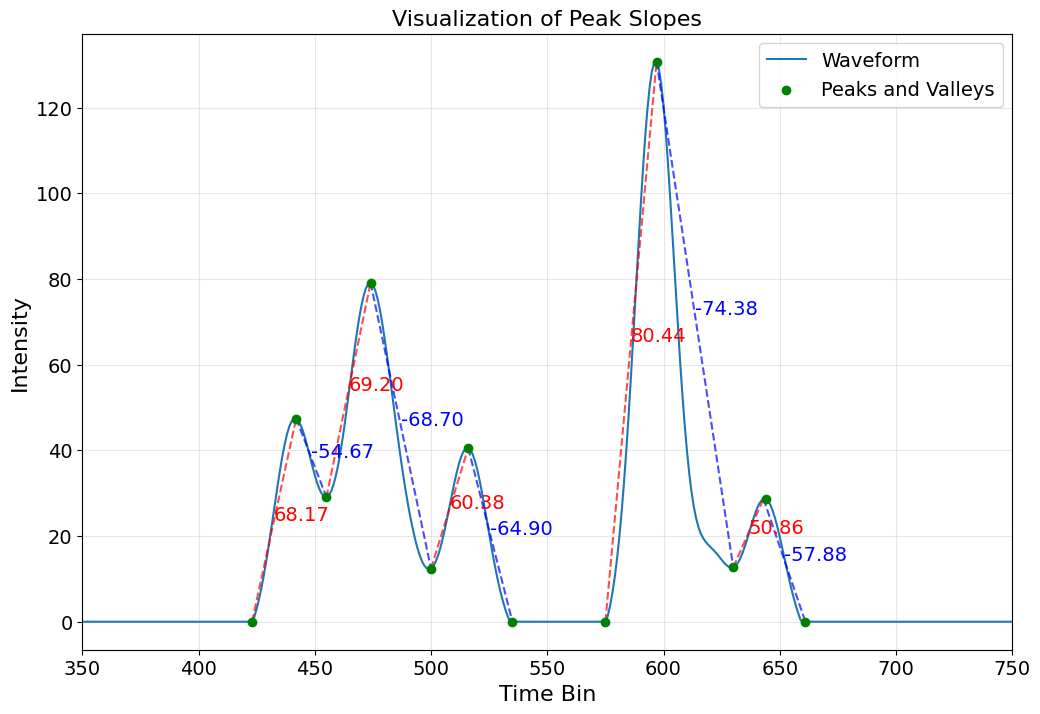

In [80]:
# Visualization for a sample waveform

sample_index = 65
waveform = waveforms[sample_index]
waveform_corrected = np.maximum(waveform - np.max(waveform)*0.05, 0)

# Calculate derivative
derivative = np.gradient(waveform_corrected)

# Find peaks
peaks, _ = find_peaks(waveform_corrected, height=np.max(waveform_corrected)*0.025)

# Identify valleys
sign_changes = np.where(np.diff(np.sign(derivative)))[0] + 1

# Plot the waveform
plt.figure(figsize=(12, 8))
x = np.arange(len(waveform_corrected))
plt.plot(x, waveform_corrected, label='Waveform', linewidth=1.5)

# Highlight the peaks and valleys
# plt.scatter(peaks, waveform_corrected[peaks], color='orange', label='Peaks', zorder=5)
plt.scatter(sign_changes, waveform_corrected[sign_changes], color='green', label='Peaks and Valleys', zorder=5)

# Annotate slopes for each peak
for peak in peaks:
    # Find the closest valleys to the left and right of the peak
    left_valley = sign_changes[sign_changes < peak][-1] if any(sign_changes < peak) else 0
    right_valley = sign_changes[sign_changes > peak+1][0] if any(sign_changes > peak) else len(waveform_corrected) - 1

    # Annotate start slope
    start_slope = np.arctan((waveform_corrected[peak] - waveform_corrected[left_valley]) / (peak - left_valley)) * (180 / np.pi)
    plt.plot([left_valley, peak], [waveform_corrected[left_valley], waveform_corrected[peak]],
             color='red', linestyle='--', alpha=0.7)
    plt.text((left_valley + peak) / 2, (waveform_corrected[left_valley] + waveform_corrected[peak]) / 2,
             f'{start_slope:.2f}', color='red')

    # Annotate end slope
    end_slope = np.arctan((waveform_corrected[right_valley] - waveform_corrected[peak]) / (right_valley - peak))* (180 / np.pi)
    plt.plot([peak, right_valley], [waveform_corrected[peak], waveform_corrected[right_valley]],
             color='blue', linestyle='--', alpha=0.7)
    plt.text((peak + right_valley) / 2, (waveform_corrected[peak] + waveform_corrected[right_valley]) / 2,
             f'{end_slope:.2f}', color='blue')

# Add labels and legend
plt.xlabel('Time Bin')
plt.ylabel('Intensity')
plt.title('Visualization of Peak Slopes')
plt.legend(loc='upper right')
plt.xlim(350,750)
plt.grid(alpha=0.3)
plt.show()

In [81]:
## 2. Statistical  (Higher order moments: Skewness, Kurtosis and Distribution data: Mean and variance)
 
# Initialize lists 
skewness_values = []
kurtosis_values = []
intensity_mean = []
intensity_std = []

# Process each waveform
for waveform in waveforms:
    # Correct for baseline (remove minimum value to avoid negative intensities)
    waveform_corrected = np.maximum(waveform - np.max(waveform)*0.05, 0)
    
    # Define the position of each time bin (assuming regular sampling)
    x = np.arange(len(waveform_corrected))
    
    # Calculate total energy (sum of intensities)
    total_energy = np.sum(waveform_corrected)
    
    # Check if there's any energy in the waveform to avoid division by zero
    if total_energy == 0:
        skewness_values.append(None)
        intensity_mean.append(None)
        intensity_variance.append(None)
        kurtosis_values.append(None)
        continue
    
    # Calculate the mean (μ) and standard deviation (σ)
    mean_value = np.sum(x * waveform_corrected) / total_energy
    variance = np.sum(waveform_corrected * (x - mean_value)**2) / total_energy
    std_dev = np.sqrt(variance)
    
    # Check if standard deviation is zero to avoid division by zero
    if std_dev == 0:
        skewness_values.append(None)
        kurtosis_values.append(None)
        continue

    # Calculate skewness (n=3) and kurtosis (n=4)
    skewness = (1 / (len(waveform_corrected) * std_dev**3)) * np.sum(waveform_corrected * (x - mean_value)**3)**(1/3)
    kurtosis = (1 / (len(waveform_corrected) * std_dev**4)) * np.sum(waveform_corrected * (x - mean_value)**4)**(1/4)
    
    # Store the results
    skewness_values.append(np.abs(skewness))
    kurtosis_values.append(np.abs(kurtosis))
    intensity_mean.append(np.mean(waveform_corrected))
    intensity_std.append(np.std(waveform_corrected))

# Convert results to numpy arrays
skewness_values = np.array(skewness_values)
kurtosis_values = np.array(kurtosis_values)
intensity_mean = np.array(intensity_mean)
intensity_std = np.array(intensity_std)

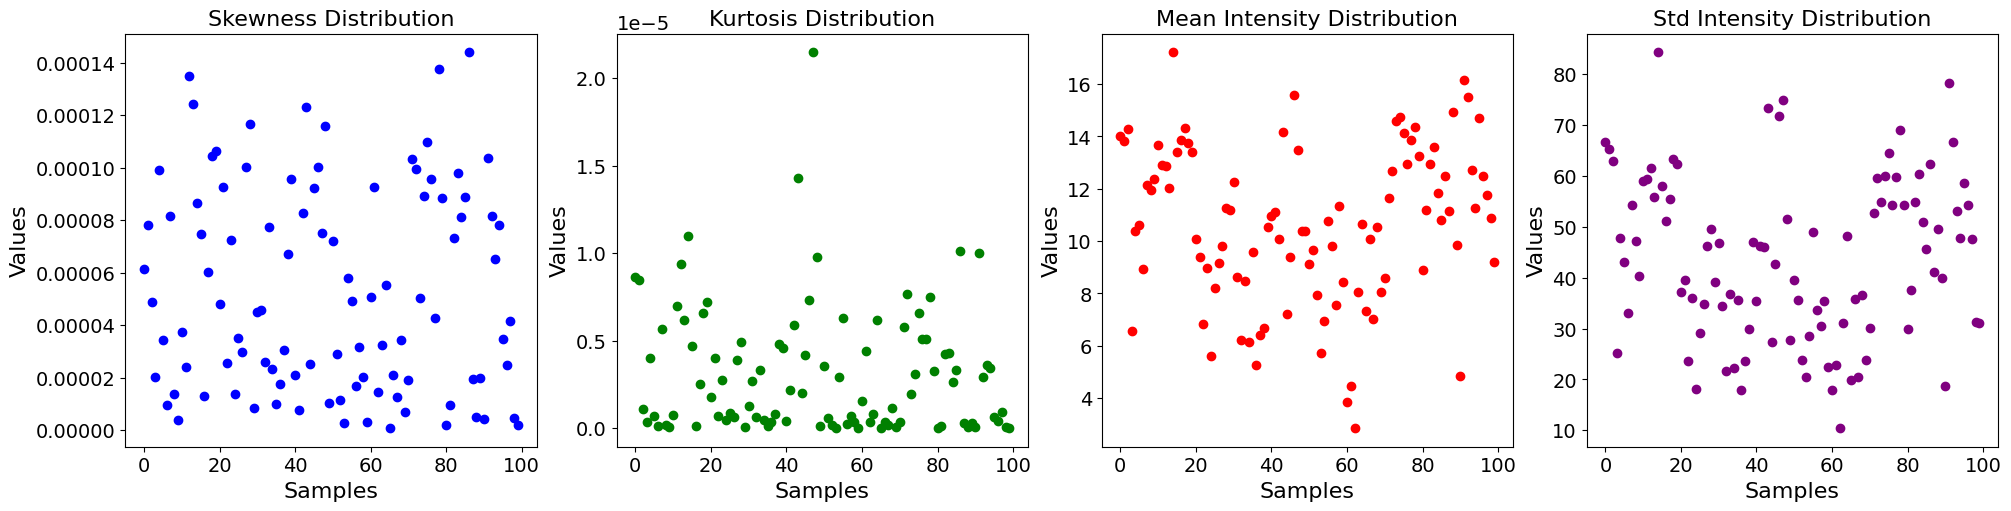

In [82]:
## Plot the Statistical metrics

i = np.arange(0, 100, 1)
# Create a figure with 1 row and 4 columns
fig, axes = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True)  # figsize adjusts overall size

# skewness
axes[0].scatter(i, skewness_values, color='b')
axes[0].set_title('Skewness Distribution')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Values')

# kurtosis
axes[1].scatter(i, kurtosis_values, color='g')
axes[1].set_title('Kurtosis Distribution')
axes[1].set_xlabel('Samples')
axes[1].set_ylabel('Values')

# mean intensity
axes[2].scatter(i, intensity_mean, color='r')
axes[2].set_title('Mean Intensity Distribution')
axes[2].set_xlabel('Samples')
axes[2].set_ylabel('Values')

# std intensity
axes[3].scatter(i, intensity_std, color='purple')
axes[3].set_title('Std Intensity Distribution')
axes[3].set_xlabel('Samples')
axes[3].set_ylabel('Values')
plt.show()


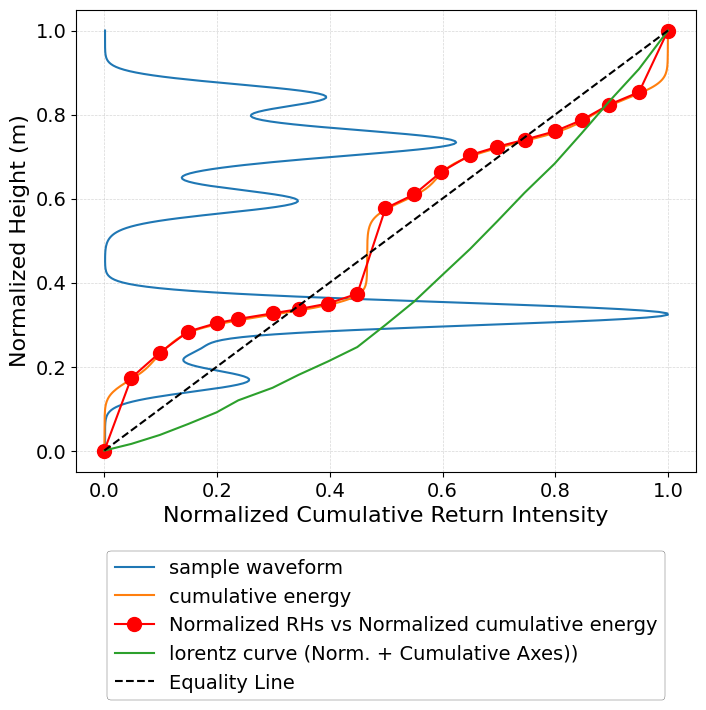

In [83]:
## 3. Entropy Based: (Ginni coefficient(GC) and Lorentz Entropy(LE))

# sample waveform
sample_waveform = waveforms[65]

# Correct the waveform by subtracting the minimum value to ensure non-negativity
waveform_corrected = np.maximum(sample_waveform - np.min(waveform), 0)

# Find peaks in the waveform
peaks, _ = find_peaks(waveform_corrected, height=np.max(waveform_corrected) * 0.025)

# Compute the derivative of the corrected waveform
derivative = np.diff(waveform_corrected)

# Find the first and last inflection points
first_inflection_point = None
last_inflection_point = None

# Last inflection point (end of last peak)
if len(peaks) > 0:
    last_peak = peaks[-1]
    for i in range(last_peak + 1, len(derivative)):
        if derivative[i] == 0.0:  # Check for zero derivative
            last_inflection_point = i
            break

# First inflection point (start of first peak)
if len(peaks) > 0:
    for i in range(len(derivative)):
        if derivative[i] > 0.0:  # Check for positive derivative
            first_inflection_point = i
            break

# Filter the waveform between the first and last inflection points
if first_inflection_point is not None and last_inflection_point is not None:
    sample_waveform_clipped = waveform_corrected[first_inflection_point:last_inflection_point+1]

# Reverse the waveform
sample_waveform_reversed = sample_waveform_clipped[::-1]
height_bins = np.arange(0, len(sample_waveform_reversed)) * 0.15      #0.15m vertical resolution

# cumulative return energy
cumulative_energy = np.cumsum(sample_waveform_reversed)
total_energy = np.sum(sample_waveform_reversed)

## Relative heights
s = 0.05         # sample size%
RH_levels = np.arange(0, 1+s, s)
RHs = np.array([np.searchsorted(cumulative_energy, level * total_energy) for level in RH_levels]) 
cumulative_energy_RH = [np.sum(sample_waveform_reversed[:rh]) for rh in RHs]

# Lorentz Curve
lorentz_height_values = np.cumsum(RHs*0.15)/np.max(np.cumsum(RHs*0.15))
lorentz_energy_values = cumulative_energy_RH/np.max(cumulative_energy_RH)

# Visualize the result for a sample waveform:
colors = []

## Plot the LAI

fig = plt.figure(figsize=(8, 6))
plt.plot(sample_waveform_reversed/np.max(sample_waveform_reversed), height_bins/np.max(height_bins), label = 'sample waveform')
plt.plot(cumulative_energy/np.max(cumulative_energy), height_bins/np.max(height_bins), label='cumulative energy')
plt.plot(cumulative_energy_RH/np.max(cumulative_energy_RH),RHs*0.15/np.max(RHs*0.15), marker = 'o', markersize=10, color='red', label='Normalized RHs vs Normalized cumulative energy' )
plt.plot(lorentz_energy_values, lorentz_height_values, label='lorentz curve (Norm. + Cumulative Axes))')
plt.plot([0, 1], [0, 1], 'k--', label="Equality Line")
# for i, y_loc in enumerate(RHs):
#     random_color = np.random.rand(3,)
    # plt.axhline(y=y_loc/np.max(RHs), color=random_color, linestyle='--', label=f'RH{int(i*100*s)} = {np.round(y_loc/np.max(RHs), 2)}', linewidth=1.5)
plt.xlabel('Normalized Cumulative Return Intensity')
plt.ylabel('Normalized Height (m)')
# plt.title('Lorentz curve')
plt.grid(linestyle = '--' , alpha= 0.5, linewidth= 0.5)
legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.25)
# fig.savefig('Gini_coefficient_plot.png', format="png", dpi=600, bbox_inches="tight")
# fig.savefig('Gini_coefficient_plot.pdf', format="pdf", dpi=600, bbox_inches="tight")
plt.show()

In [84]:
# Calculate Gini coefficient and Lorentz entropy for all the waveforms 

def calculate_gini_lorenz(y, interval_width=0.05):
    # Ensure F(y) starts at 0 and ends at 1
    y = np.array(y)
    if y[0] != 0: y = np.insert(y, 0, 0)
    if y[-1] != 1: y = np.append(y, 1)
    
    k = len(y)  # Total bins
    n = k - 1   # Number of intervals (20 for 5% bins)
    correction_factor = n / (n - 1)  # Sample bias correction
    
    # Compute area under the Lorenz curve 
    area = 0
    for i in range(1, k):
        area += ((y[i] + y[i-1]) / 2) * interval_width
    
    # Compute Gini Coefficient 
    gini_coefficient = correction_factor * (0.5 - area)
    
    # Compute Lorenz Entropy (Deviation of Lorenz Curve)
    lorenz_entropy = 1 - (np.abs((1/3) - gini_coefficient))
    
    return gini_coefficient, lorenz_entropy

# Initialize empty lists 
Gini_coefficients = []  
Lorentz_entropies = [] 

# Loop over all waveforms
for waveform in waveforms:
   
    waveform_corrected = np.maximum(waveform - np.max(waveform)*0.05, 0)
    peaks, _ = find_peaks(waveform_corrected, height=np.max(waveform_corrected) * 0.025)
    derivative = np.diff(waveform_corrected)
    
    # Identify first and last inflection points
    first_inflection_point = None
    last_inflection_point = None

    # Last inflection point (end of last peak)
    if len(peaks) > 0:
        last_peak = peaks[-1]
        for i in range(last_peak + 1, len(derivative)):
            if derivative[i] == 0.0:
                last_inflection_point = i
                break

    # First inflection point (start of first peak)
    if len(peaks) > 0:
        for i in range(len(derivative)):
            if derivative[i] > 0.0:
                first_inflection_point = i
                break

    # Filter the waveform between the first and last inflection points
    if first_inflection_point is not None and last_inflection_point is not None:
        waveform_clipped = waveform_corrected[first_inflection_point:last_inflection_point+1]
    else:
        waveform_clipped = waveform_corrected

    # Reverse the waveform
    waveform_reversed = waveform_clipped[::-1]
    height_bins = np.arange(0, len(waveform_reversed)) * 0.15  # Vertical resolution

    # Compute cumulative energy and total energy
    cumulative_energy = np.cumsum(waveform_reversed)
    total_energy = np.sum(waveform_reversed)

    # Compute relative heights
    s = 0.05  # Sample size %
    RH_levels = np.arange(0, 1 + s, s)
    RHs = np.array([np.searchsorted(cumulative_energy, level * total_energy) for level in RH_levels]) 
    cumulative_energy_RH = [np.sum(waveform_reversed[:rh]) for rh in RHs]

    # Lorenz Curve
    lorentz_height_values = np.cumsum(RHs * 0.15) / np.max(np.cumsum(RHs * 0.15))
    lorentz_energy_values = cumulative_energy_RH / np.max(cumulative_energy_RH)

    # Calculate Gini Coefficient and Lorentz Entropy
    G, L = calculate_gini_lorenz(lorentz_height_values, s)
    
    # Append the results
    Gini_coefficients.append(G)
    Lorentz_entropies.append(L)

# Convert numpy arrays
GC = np.array(Gini_coefficients)
LE = np.array(Lorentz_entropies)

[]

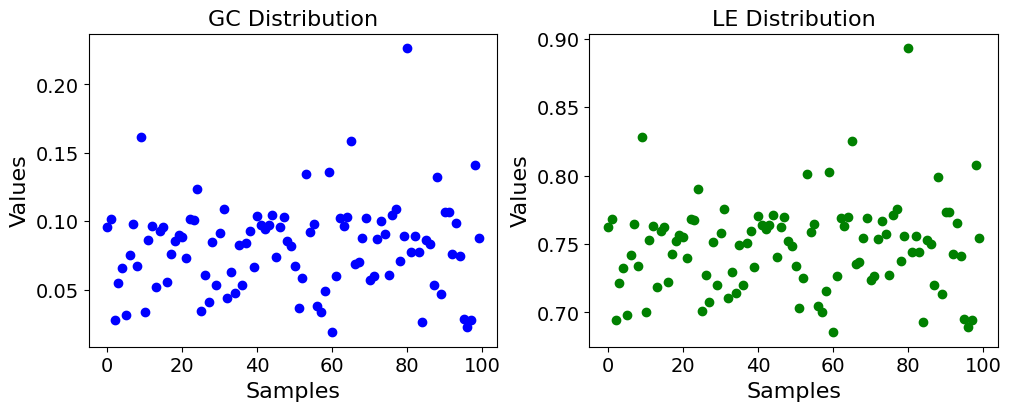

In [85]:
## Plot of GC and LE
i = np.arange(0, 100, 1)
# Create a figure with 1 row and 4 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)  # figsize adjusts overall size

# skewness
axes[0].scatter(i, GC, color='b')
axes[0].set_title('GC Distribution')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Values')

# kurtosis
axes[1].scatter(i, LE, color='g')
axes[1].set_title('LE Distribution')
axes[1].set_xlabel('Samples')
axes[1].set_ylabel('Values')
plt.plot()

In [86]:
## 4. Centroid and Radius of Gyration (2D: Geometrical):

# Initialize empty lists 
Cx_geom = []  # X-coordinate of the centroid (intensity axis)
Cy_geom = []  # Y-coordinate of the centroid  (Height axis)
radii_of_gyration_geom = []  # Radius of Gyration 

# Loop over all waveforms
for waveform in waveforms[:]:
    waveform_corrected = np.maximum(waveform - np.max(waveform)*0.05, 0)
    peaks, _ = find_peaks(waveform_corrected, height=np.max(waveform_corrected) * 0.025)
    derivative = np.diff(waveform_corrected)
    
    # Identify first and last inflection points
    first_inflection_point = None
    last_inflection_point = None

    # Last inflection point (end of last peak)
    if len(peaks) > 0:
        last_peak = peaks[-1]
        for i in range(last_peak + 1, len(derivative)):
            if derivative[i] == 0.0:
                last_inflection_point = i
                break

    # First inflection point (start of first peak)
    if len(peaks) > 0:
        for i in range(len(derivative)):
            if derivative[i] > 0.0:
                first_inflection_point = i
                break

    # Filter the waveform between the first and last inflection points
    if first_inflection_point is not None and last_inflection_point is not None:
        waveform_clipped = waveform_corrected[first_inflection_point:last_inflection_point+1]
    else:
        waveform_clipped = waveform_corrected

    # Reverse the waveform
    waveform_reversed = waveform_clipped[::-1]

    # Create the waveform
    y = np.arange(0, len(waveform_reversed)) * 0.15
    x = np.array(waveform_reversed, dtype=float)

    # Arc length
    dx = np.diff(x)
    dy = np.diff(y)
    arc_lengths = np.sqrt(dx**2 + dy**2)  # Arc lengths between consecutive points
    total_length = np.sum(arc_lengths)  # Total arc length (L)

    # Calculate weighted averages for centroid (Cx, Cy)
    Cx = np.sum((x[:-1] + x[1:]) / 2 * arc_lengths) / total_length
    Cy = np.sum((y[:-1] + y[1:]) / 2 * arc_lengths) / total_length

    # Radius of Gyration:
    RG = np.sqrt(np.sum((x - Cx)**2 + (y - Cy)**2) / len(x))

    # Append results 
    Cx_geom.append(Cx)
    Cy_geom.append(Cy)
    radii_of_gyration_geom.append(RG)

# Convert lists to numpy arrays
Cx_geom = np.array(Cx_geom, dtype=float)
Cy_geom = np.array(Cy_geom, dtype=float)
radii_of_gyration_geom = np.array(radii_of_gyration_geom, dtype=float)

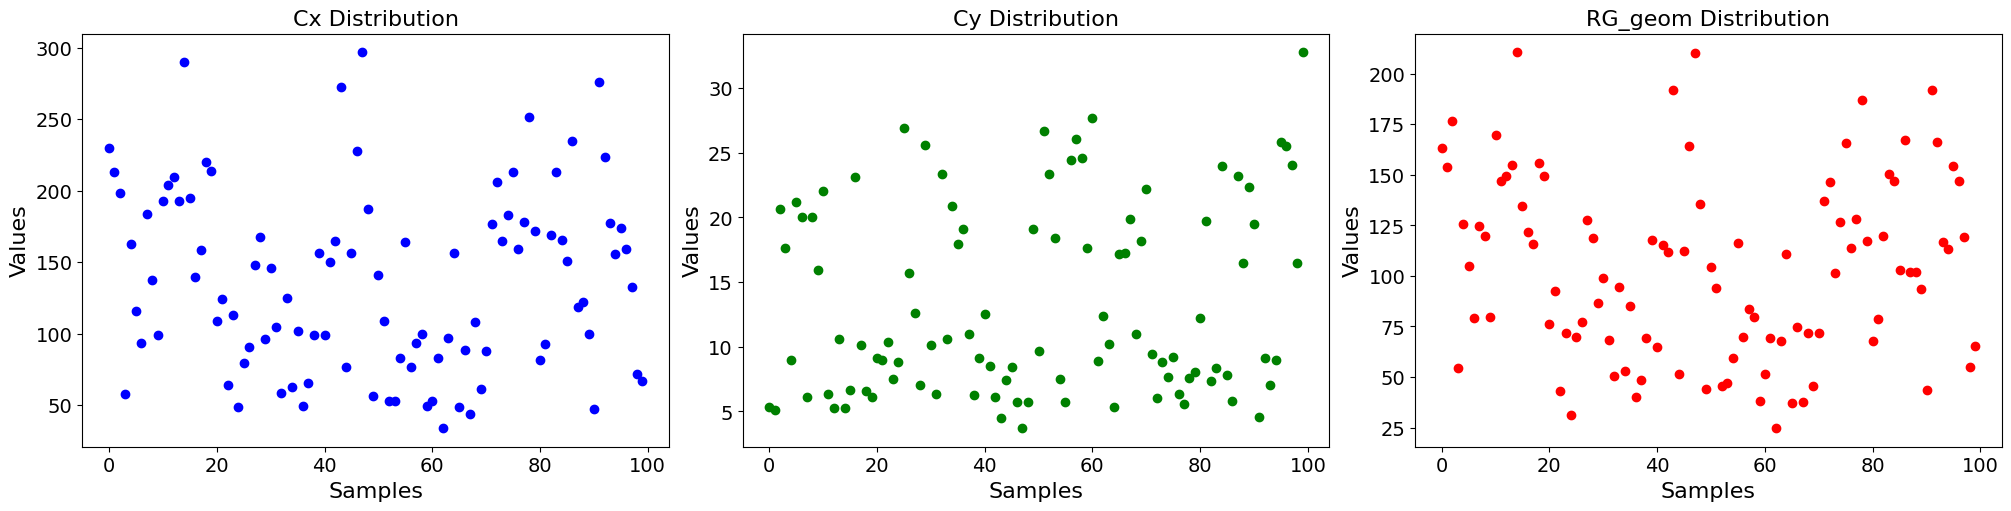

In [87]:
## Plot Cx, Cy and RG

i = np.arange(0, len(Cx_geom))
# Create a figure with 1 row and 4 columns
fig, axes = plt.subplots(1, 3, figsize=(20, 5), constrained_layout=True)  # figsize adjusts overall size

# skewness
axes[0].scatter(i, Cx_geom, color='b')
axes[0].set_title('Cx Distribution')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Values')

# kurtosis
axes[1].scatter(i, Cy_geom, color='g')
axes[1].set_title('Cy Distribution')
axes[1].set_xlabel('Samples')
axes[1].set_ylabel('Values')

# mean intensity
axes[2].scatter(i, radii_of_gyration_geom, color='r')
axes[2].set_title('RG_geom Distribution')
axes[2].set_xlabel('Samples')
axes[2].set_ylabel('Values')

plt.show()

In [88]:
# # # Save all the metrics files as numpy arrays for raw and deconvolved data:

# directory = 'gold_deconvolved'
# np.save(f'./All_flightline_data/{directory}/intensity_std_{fl}', intensity_std)
# np.save(f'./All_flightline_data/{directory}/intensity_mean_{fl}', intensity_mean)
# np.save(f'./All_flightline_data/{directory}/centroids1d_{fl}', centroids1d)
# np.save(f'./All_flightline_data/{directory}/radii_of_gyration1d_{fl}', radii_of_gyration1d)
# np.save(f'./All_flightline_data/{directory}/Cx_geom_{fl}', Cx_geom)
# np.save(f'./All_flightline_data/{directory}/Cy_geom_{fl}', Cy_geom)
# np.save(f'./All_flightline_data/{directory}/radii_of_gyration_geom_{fl}', radii_of_gyration_geom)
# np.save(f'./All_flightline_data/{directory}/RH25_{fl}', rh25_values)
# np.save(f'./All_flightline_data/{directory}/RH50_{fl}', rh50_values)
# np.save(f'./All_flightline_data/{directory}/RH75_{fl}', rh75_values)
# np.save(f'./All_flightline_data/{directory}/RH100_{fl}', rh100_values)
# np.save(f'./All_flightline_data/{directory}/canopy_heights_{fl}', canopy_heights)
# np.save(f'./All_flightline_data/{directory}/rough_values_{fl}', rough_values)
# np.save(f'./All_flightline_data/{directory}/front_slope_angles_{fl}', front_slope_angles)
# np.save(f'./All_flightline_data/{directory}/number_of_peaks_{fl}', number_of_peaks)
# np.save(f'./All_flightline_data/{directory}/waveform_distances_{fl}', waveform_distances)
# np.save(f'./All_flightline_data/{directory}/htmr_values_{fl}', htmr_values)
# np.save(f'./All_flightline_data/{directory}/vdr_values_{fl}', vdr_values)
# np.save(f'./All_flightline_data/{directory}/RWE_{fl}', total_return_energies)
# np.save(f'./All_flightline_data/{directory}/mean_start_slopes_{fl}', mean_start_slopes)
# np.save(f'./All_flightline_data/{directory}/std_start_slopes_{fl}', std_start_slopes)
# np.save(f'./All_flightline_data/{directory}/ratio_start_slopes_{fl}', ratio_start_slopes)
# np.save(f'./All_flightline_data/{directory}/ratio_end_slopes_{fl}', ratio_end_slopes)
# np.save(f'./All_flightline_data/{directory}/mean_end_slopes_{fl}', mean_end_slopes)
# np.save(f'./All_flightline_data/{directory}/std_end_slopes_{fl}', std_end_slopes)
# np.save(f'./All_flightline_data/{directory}/veg_to_ground_slope_ratio_{fl}', veg_to_ground_slope_ratio)
# np.save(f'./All_flightline_data/{directory}/kurtosis_{fl}', kurtosis_values)
# np.save(f'./All_flightline_data/{directory}/skewness_{fl}', skewness_values)
# np.save(f'./All_flightline_data/{directory}/GC_{fl}', GC)
# np.save(f'./All_flightline_data/{directory}/LE_{fl}', LE)